In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

sentences = [
    "The cats are running quickly in the garden.",
    "John studies hard, but he still struggles with mathematics.",
    "She went to the market and bought fresh vegetables.",
    "Playing soccer every weekend keeps him active.",
    "The children’s toys were scattered all over the floor.",
    "He was driving carefully when the accident happened.",
    "'Don’t forget to call me back,' she said.",
    "The happiest moment of my life was my graduation.",
    "They have been waiting for this opportunity for years.",
    "The dog is running on the beach.",
    "Kitty is the baby of a cat."
]
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    nltk_tokens = word_tokenize(text)

    nltk_processed = [lemmatizer.lemmatize(token.lower()) for token in nltk_tokens if token.lower() not in stop_words and token.isalpha()]
    return nltk_processed

processed_texts = [preprocess_text(text) for text in sentences]
processed_texts

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aliha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aliha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aliha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[['cat', 'running', 'quickly', 'garden'],
 ['john', 'study', 'hard', 'still', 'struggle', 'mathematics'],
 ['went', 'market', 'bought', 'fresh', 'vegetable'],
 ['playing', 'soccer', 'every', 'weekend', 'keep', 'active'],
 ['child', 'toy', 'scattered', 'floor'],
 ['driving', 'carefully', 'accident', 'happened'],
 ['forget', 'call', 'back', 'said'],
 ['happiest', 'moment', 'life', 'graduation'],
 ['waiting', 'opportunity', 'year'],
 ['dog', 'running', 'beach'],
 ['kitty', 'baby', 'cat']]

In [2]:
from gensim.models import Word2Vec

cbow_model = Word2Vec(sentences=processed_texts, vector_size=100, window=5, min_count=1, sg=0)

skipgram_model = Word2Vec(sentences=processed_texts, vector_size=100, window=5, min_count=1, sg=1)

cbow_model.train(processed_texts, total_examples=len(processed_texts), epochs=100)
skipgram_model.train(processed_texts, total_examples=len(processed_texts), epochs=100)

print(cbow_model.wv['cat'][:5])  
print(skipgram_model.wv['cat'][:5])

[-0.00053571  0.00026097  0.00508691  0.00903807 -0.00937082]
[-0.0005061   0.00028432  0.00514444  0.00908558 -0.00943634]


In [3]:
glove_embeddings = {}
with open("glove.6B.100d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glove_embeddings[word] = vector

print(glove_embeddings['cat'][:5])

[ 0.23088  0.28283  0.6318  -0.59411 -0.58599]


In [4]:
from gensim.models import FastText

fasttext_model = FastText(sentences=processed_texts, vector_size=100, window=5, min_count=1)
print(fasttext_model.wv['cat'][:5])

[-0.00213783 -0.00093409 -0.00097967  0.00322654 -0.00202755]


In [5]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

words = ['cat', 'dog']
cbow_vecs = [cbow_model.wv[word] for word in words]
skipgram_vecs = [skipgram_model.wv[word] for word in words]
glove_vecs = [glove_embeddings[word] for word in words]
fasttext_vecs = [fasttext_model.wv[word] for word in words]

print("CBOW similarity:", cosine_similarity([cbow_vecs[0]], [cbow_vecs[1]])[0][0])
print("Skip-gram similarity:", cosine_similarity([skipgram_vecs[0]], [skipgram_vecs[1]])[0][0])
print("GloVe similarity:", cosine_similarity([glove_vecs[0]], [glove_vecs[1]])[0][0])
print("FastText similarity:", cosine_similarity([fasttext_vecs[0]], [fasttext_vecs[1]])[0][0])

CBOW similarity: -0.13477615
Skip-gram similarity: -0.13428223
GloVe similarity: 0.8798075
FastText similarity: -0.11531018


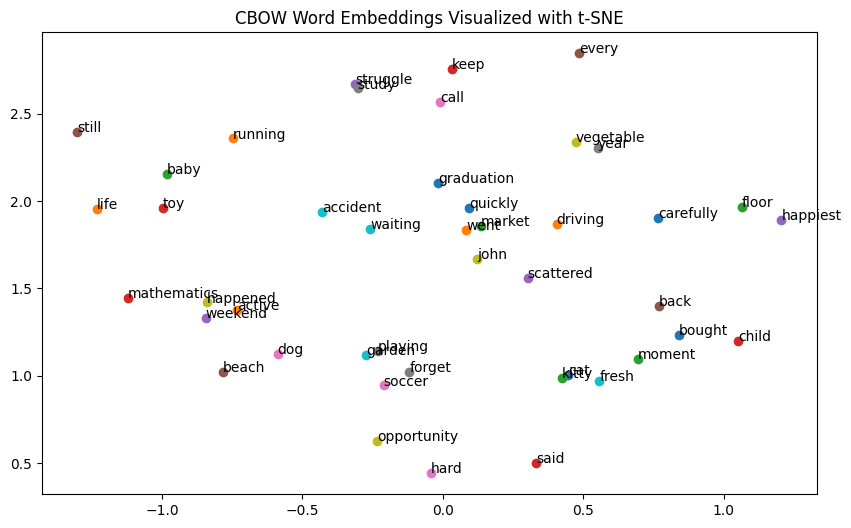

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

words = cbow_model.wv.index_to_key  
vectors = [cbow_model.wv[word] for word in words]

tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(np.array(vectors))

plt.figure(figsize=(10, 6))
for i, word in enumerate(words):
    plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1])
    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]))
plt.title("CBOW Word Embeddings Visualized with t-SNE")
plt.show()

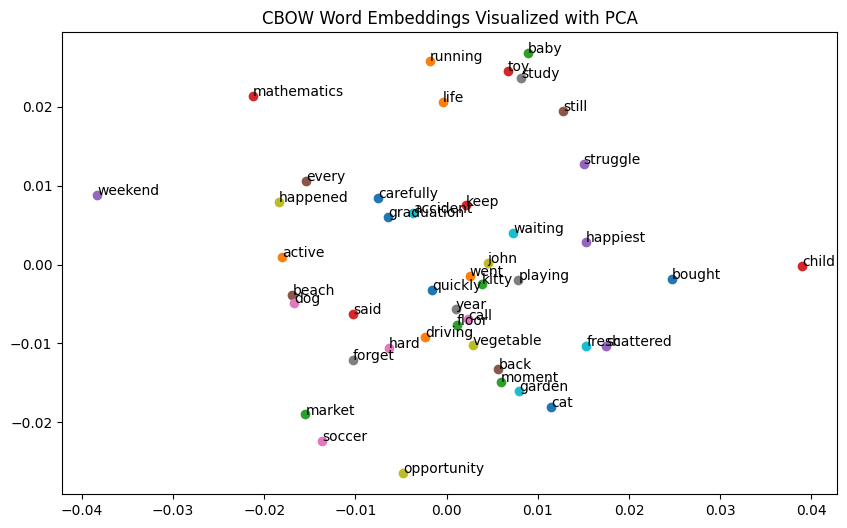

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

words = cbow_model.wv.index_to_key  
vectors = [cbow_model.wv[word] for word in words]

tsne = PCA(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(np.array(vectors))

plt.figure(figsize=(10, 6))
for i, word in enumerate(words):
    plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1])
    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]))
plt.title("CBOW Word Embeddings Visualized with PCA")
plt.show()

# RNN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import random
import matplotlib.pyplot as plt
from datasets import load_dataset
import re
from collections import Counter
import time

In [2]:
dataset = load_dataset('imdb')

train_data = dataset['train']
test_data  = dataset['test']


In [3]:
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9'\s]", '', text)
    tokens = text.split()
    return tokens

tokens = []
for item in train_data:
    tokens.extend(tokenize(item['text']))

vocab_size = 10000
counts = Counter(tokens)
vocab = sorted(counts, key=counts.get, reverse=True)[:vocab_size-2] 

word2idx = {'<PAD>': 0, '<UNK>': 1}
for i, w in enumerate(vocab, start=2):
    word2idx[w] = i

idx2word = {v: k for k, v in word2idx.items()}

def text_to_sequence(text, word2idx, max_length=200):
    tokens = tokenize(text)
    seq = []
    for t in tokens:
        seq.append(word2idx[t] if t in word2idx else word2idx['<UNK>'])

    seq = seq[:max_length]
    seq += [word2idx['<PAD>']] * (max_length - len(seq))
    return seq


In [4]:
class IMDBDataset(Dataset):
    def __init__(self, dataset, word2idx, max_length=200):
        self.data = dataset
        self.word2idx = word2idx
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data[idx]['text']
        label = self.data[idx]['label']
        
        seq = text_to_sequence(text, self.word2idx, self.max_length)
        seq = torch.tensor(seq, dtype=torch.long)
        label = torch.tensor(label, dtype=torch.long)
        
        return seq, label

max_length = 200
train_dataset = IMDBDataset(train_data, word2idx, max_length=max_length)
test_dataset  = IMDBDataset(test_data,  word2idx, max_length=max_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)


In [12]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size=2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        embedded = self.embedding(x)  
        output, hidden = self.rnn(embedded)  
        last_hidden = hidden[-1]
        
        logits = self.fc(last_hidden)  
        return logits


In [23]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

gradients = []
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=5, device='cpu'):
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        losses = 0.0
        correct = 0
        total = 0
        
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            
            embedding_grad = model.embedding.weight.grad
            grad_value = embedding_grad.norm().item()
            gradients.append(grad_value)
            
            optimizer.step()
            
            losses += loss.item() * sequences.size(0)
            
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_train_loss = losses / len(train_loader.dataset)
        epoch_train_acc = correct / total
        
        #testing
        model.eval()
        losses_test = 0.0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for sequences, labels in test_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                losses_test += loss.item() * sequences.size(0)
                
                _, predicted = torch.max(outputs, dim=1)
                correct_test += (predicted == labels).sum().item()
                total_test += labels.size(0)
        
        epoch_test_loss = losses_test / len(test_loader.dataset)
        epoch_test_acc = correct_test / total_test
        
        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)
        train_accuracies.append(epoch_train_acc)
        test_accuracies.append(epoch_test_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] " 
              f"Train Loss: {epoch_train_loss:.5f} Train Acc: {epoch_train_acc:.5f} "
              f"Test Loss: {epoch_test_loss:.5f} Test Acc: {epoch_test_acc:.5f}")
    
    return train_losses, test_losses, train_accuracies, test_accuracies, gradients


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
model = RNN(vocab_size=vocab_size, embed_dim=128, hidden_size=128, output_size=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
train_losses, test_losses, train_acc, test_acc, gradients = train_model_and_evaluate(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs, device=device
)


Epoch [1/10] Train Loss: 0.6984 Train Acc: 0.4996 Test Loss: 0.6950 Test Acc: 0.4953
Epoch [2/10] Train Loss: 0.6964 Train Acc: 0.5130 Test Loss: 0.7040 Test Acc: 0.5004
Epoch [3/10] Train Loss: 0.6971 Train Acc: 0.5110 Test Loss: 0.6971 Test Acc: 0.5074
Epoch [4/10] Train Loss: 0.6938 Train Acc: 0.5193 Test Loss: 0.6963 Test Acc: 0.5111
Epoch [5/10] Train Loss: 0.6844 Train Acc: 0.5382 Test Loss: 0.7033 Test Acc: 0.5068
Epoch [6/10] Train Loss: 0.6723 Train Acc: 0.5516 Test Loss: 0.7117 Test Acc: 0.5158
Epoch [7/10] Train Loss: 0.6568 Train Acc: 0.5649 Test Loss: 0.7197 Test Acc: 0.5212
Epoch [8/10] Train Loss: 0.6395 Train Acc: 0.5830 Test Loss: 0.7289 Test Acc: 0.5249
Epoch [9/10] Train Loss: 0.6428 Train Acc: 0.5997 Test Loss: 0.7159 Test Acc: 0.5225
Epoch [10/10] Train Loss: 0.6351 Train Acc: 0.5994 Test Loss: 0.7549 Test Acc: 0.5969


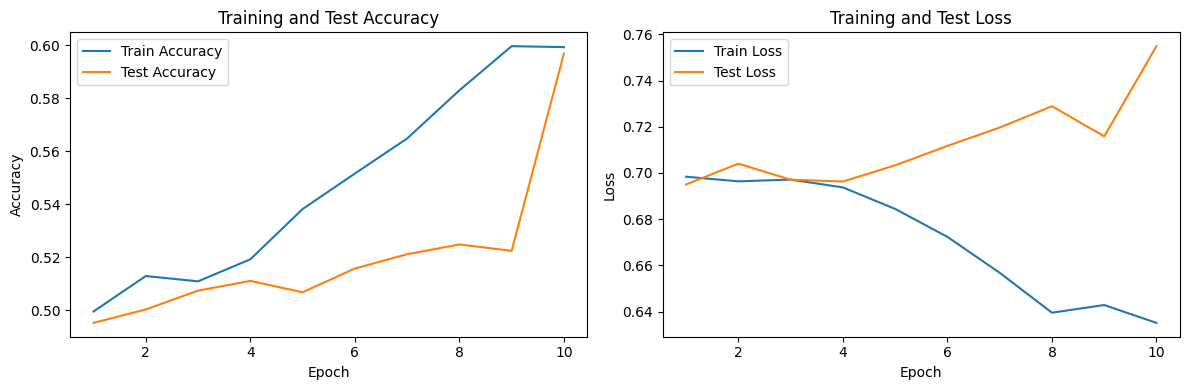

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_acc, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\aliha\AppData\Local\Temp\ipykernel_8416\84731355.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


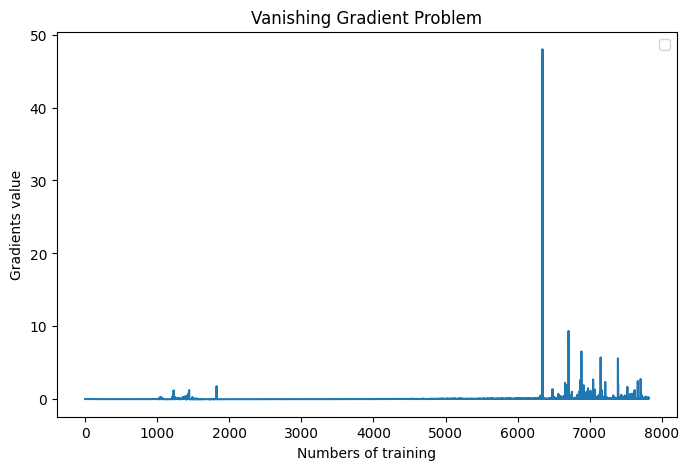

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(gradients)
plt.xlabel('Numbers of training')
plt.ylabel('Gradients value')
plt.title('Vanishing Gradient Problem')
plt.legend()
plt.show()

# LSTM & GRU

In [8]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size=2):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        embedded = self.embedding(x)            
        output, (hidden, cell) = self.lstm(embedded)  
        last_hidden = hidden[-1]                
        logits = self.fc(last_hidden)          
        return logits

class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size=2):
        super(GRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        embedded = self.embedding(x)            
        output, hidden = self.gru(embedded)     
        last_hidden = hidden[-1]               
        logits = self.fc(last_hidden)          
        return logits


In [30]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=5, device='cpu'):
    model.to(device)
    
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        losses = 0.0
        correct = 0
        total = 0
        
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses += loss.item() * sequences.size(0)
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_train_loss = losses / len(train_loader.dataset)
        epoch_train_acc = correct / total

        #eval
        model.eval()
        losses_test = 0.0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for sequences, labels in test_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                losses_test += loss.item() * sequences.size(0)
                
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == labels).sum().item()
                total_test += labels.size(0)
        
        epoch_test_loss = losses_test / len(test_loader.dataset)
        epoch_test_acc = correct_test / total_test
        
        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)
        train_accs.append(epoch_train_acc)
        test_accs.append(epoch_test_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_train_loss:.5f}  Train Acc: {epoch_train_acc:.5f} | "
              f"Test Loss: {epoch_test_loss:.5f}  Test Acc: {epoch_test_acc:.5f}")
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    return train_losses, test_losses, train_accs, test_accs, elapsed_time


In [31]:
lstm_model = LSTMClassifier(len(word2idx), embed_dim=128, hidden_size=128, output_size=2)
num_epochs = 5
optimizer = optim.Adam(lstm_model.parameters(), lr=1e-3)

print("###### Training LSTM Model ######")
lstm_train_losses, lstm_test_losses, lstm_train_accs, lstm_test_accs, lstm_time = \
    train_and_evaluate(lstm_model, train_loader, test_loader, criterion, optimizer, num_epochs, device)

# ---- GRU ----
gru_model = GRUClassifier(len(word2idx), embed_dim=128, hidden_size=128, output_size=2)
optimizer = optim.Adam(gru_model.parameters(), lr=1e-3)

print("###### Training GRU Model ######")
gru_train_losses, gru_test_losses, gru_train_accs, gru_test_accs, gru_time = \
    train_and_evaluate(gru_model, train_loader, test_loader, criterion, optimizer, num_epochs, device)


###### Training LSTM Model ######
5
Epoch [1/5] Train Loss: 0.6931  Train Acc: 0.5120 | Test Loss: 0.6863  Test Acc: 0.5298
Epoch [2/5] Train Loss: 0.6844  Train Acc: 0.5407 | Test Loss: 0.6893  Test Acc: 0.5289
Epoch [3/5] Train Loss: 0.6641  Train Acc: 0.5829 | Test Loss: 0.6842  Test Acc: 0.5406
Epoch [4/5] Train Loss: 0.6026  Train Acc: 0.6617 | Test Loss: 0.6379  Test Acc: 0.6970
Epoch [5/5] Train Loss: 0.4956  Train Acc: 0.7640 | Test Loss: 0.4593  Test Acc: 0.7967
###### Training GRU Model ######
5
Epoch [1/5] Train Loss: 0.6950  Train Acc: 0.5162 | Test Loss: 0.6875  Test Acc: 0.5487
Epoch [2/5] Train Loss: 0.6586  Train Acc: 0.6065 | Test Loss: 0.5621  Test Acc: 0.7172
Epoch [3/5] Train Loss: 0.3948  Train Acc: 0.8192 | Test Loss: 0.3568  Test Acc: 0.8374
Epoch [4/5] Train Loss: 0.2422  Train Acc: 0.9044 | Test Loss: 0.3597  Test Acc: 0.8422
Epoch [5/5] Train Loss: 0.1521  Train Acc: 0.9455 | Test Loss: 0.3932  Test Acc: 0.8560


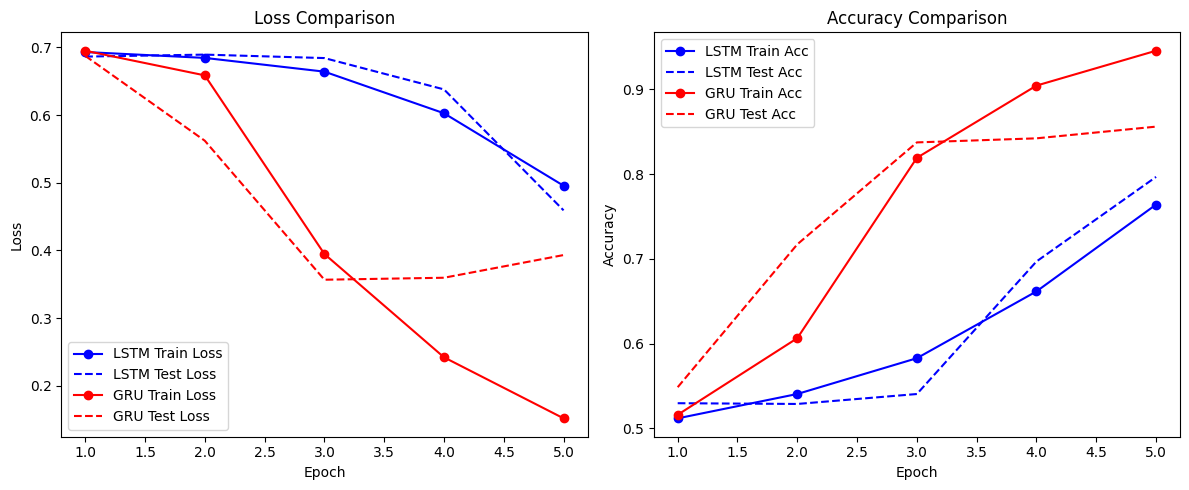

In [33]:
num_epochs=5
epochs_range = range(1, num_epochs+1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, lstm_train_losses[:5], 'b-o', label='LSTM Train Loss')
plt.plot(epochs_range, lstm_test_losses, 'b--', label='LSTM Test Loss')
plt.plot(epochs_range, gru_train_losses, 'r-o', label='GRU Train Loss')
plt.plot(epochs_range, gru_test_losses, 'r--', label='GRU Test Loss')
plt.title("Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, lstm_train_accs, 'b-o', label='LSTM Train Acc')
plt.plot(epochs_range, lstm_test_accs, 'b--', label='LSTM Test Acc')
plt.plot(epochs_range, gru_train_accs, 'r-o', label='GRU Train Acc')
plt.plot(epochs_range, gru_test_accs, 'r--', label='GRU Test Acc')
plt.title("Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [35]:
print("Final Results")
print(f"LSTM - Test Accuracy: {lstm_test_accs[-1]:.5f}, Training Time: {lstm_time:.2f} sec")
print(f"GRU  - Test Accuracy: {gru_test_accs[-1]:.5f}, Training Time: {gru_time:.2f} sec")


Final Results
LSTM - Final Test Accuracy: 0.7967, Training Time: 143.80 sec
GRU  - Final Test Accuracy: 0.8560, Training Time: 138.13 sec


# LSTM text generation

In [36]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

shakespeare_text = """
Shall I compare thee to a summer's day 
Thou art more lovely and more temperate 
Rough winds do shake the darling buds of May 
And summer's lease hath all too short a date 
Sometime too hot the eye of heaven shines 
And often is his gold complexion dimmed 
And every fair from fair sometime declines 
By chance or nature's changing course untrimmed 
But thy eternal summer shall not fade 
Nor lose possession of that fair thou ow'st 
Nor shall death brag thou wander'st in his shade 
When in eternal lines to time thou grow'st 
So long as men can breathe or eyes can see 
So long lives this and this gives life to thee
"""


In [37]:
tokens = tokenize(shakespeare_text)
word_counts = Counter(tokens)
sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
word2idx = {word: i for i, word in enumerate(sorted_vocab)}
idx2word = {i: word for word, i in word2idx.items()}

vocab_size = len(word2idx)
print("Vocab size:", vocab_size)


Vocab size: 83


In [38]:
seq_length = 5 
sequences = []
targets = []

for i in range(len(tokens) - seq_length):
    input_seq = tokens[i : i + seq_length]
    target_word = tokens[i + seq_length]
    
    input_seq_idx = [word2idx[w] for w in input_seq]
    target_idx = word2idx[target_word]
    
    sequences.append(input_seq_idx)
    targets.append(target_idx)

sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

print(len(sequences))

109


In [39]:
dataset = TensorDataset(sequences, targets)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [40]:
class LSTMTextGenerator(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden_state=None):
        embedded = self.embedding(x)  
        if hidden_state is None:
            out, hidden_state = self.lstm(embedded)
        else:
            out, hidden_state = self.lstm(embedded, hidden_state)
        last_time_step = out[:, -1, :]          
        logits = self.fc(last_time_step)        
        return logits, hidden_state
    
    def init_hidden(self, batch_size, hidden_dim, device):
        h0 = torch.zeros(1, batch_size, hidden_dim).to(device)
        c0 = torch.zeros(1, batch_size, hidden_dim).to(device)
        return (h0, c0)


In [41]:
def train_model(model, data_loader,optimizer, vocab_size, epochs=30, lr=0.01, device='cpu'):
    model.to(device)
    
    for epoch in range(1, epochs+1):
        model.train()
        losses = 0
        for sequences, targets in data_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            
            optimizer.zero_grad()
            logits, _ = model(sequences)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()
            
            losses += loss.item()
        
        avg_loss = losses / len(data_loader)
        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch [{epoch}/{epochs}], Loss: {avg_loss:.5f}")


In [42]:
model = LSTMTextGenerator(vocab_size, 64, 128)
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_model(model, data_loader,optimizer,  vocab_size, epochs=50, lr=0.01, device=device)

Epoch [1/50], Loss: 4.4959
Epoch [5/50], Loss: 0.0939
Epoch [10/50], Loss: 0.0080
Epoch [15/50], Loss: 0.0044
Epoch [20/50], Loss: 0.0028
Epoch [25/50], Loss: 0.0020
Epoch [30/50], Loss: 0.0015
Epoch [35/50], Loss: 0.0012
Epoch [40/50], Loss: 0.0010
Epoch [45/50], Loss: 0.0008
Epoch [50/50], Loss: 0.0007


In [43]:
def generate_text(model, seed_text, num_words=20, device='cpu'):
    model.eval()
    
    seed_tokens = tokenize(seed_text)
    seed_indices = [word2idx.get(w, word2idx[sorted_vocab[-1]]) 
                    if w in word2idx else word2idx[sorted_vocab[-1]] 
                    for w in seed_tokens]
    
    current_seq = seed_indices[-seq_length:] 
    generated_words = seed_tokens[:] 
    hidden = None 
    for _ in range(num_words):
        input_seq = torch.tensor([current_seq], dtype=torch.long).to(device)
        
        with torch.no_grad():
            logits, hidden = model(input_seq, hidden)
            probs = torch.softmax(logits, dim=-1).squeeze()
        
        next_word_idx = torch.argmax(probs).item()
        generated_words.append(idx2word[next_word_idx])
        
        current_seq = current_seq[1:] + [next_word_idx]
    
    return " ".join(generated_words)


In [44]:
seed = "Shall I compare"
generated = generate_text(model, seed, num_words=20, device=device)
print("Word seed:", seed)
print("Result:", generated)

Word seed: Shall I compare
Result: shall i compare a summer's day thou art more lovely and more temperate rough winds do shake the darling buds of may and


In [45]:
seed = "Is it you or not"
generated = generate_text(model, seed, num_words=20, device=device)
print("Word seed:", seed)
print("Result:", generated)

Word seed: Is it you or not
Result: is it you or not time thou grow'st so long as men can breathe or eyes can see so long lives this and this gives


# BiLSTM and LSTM

In [5]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        embedded = self.embedding(x)                
        out, (hidden, cell) = self.lstm(embedded)
        forward_hidden = hidden[-2,:,:]             
        backward_hidden = hidden[-1,:,:]            
        last_hidden = torch.cat([forward_hidden, backward_hidden], dim=1)  
        logits = self.fc(last_hidden)              
        return logits


In [6]:
def train_and_evaluate(model, train_loader, test_loader, num_epochs=5, lr=1e-3, device='cpu'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    
    for epoch in range(num_epochs):
        model.train()
        losses = 0
        correct, total = 0, 0
        
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = losses / len(train_loader.dataset)
        epoch_acc = correct / total
        
        model.eval()
        losses_test = 0
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for sequences, labels in test_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                
                losses_test += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, dim=1)
                correct_test += (predicted == labels).sum().item()
                total_test += labels.size(0)
        
        epoch_loss_test = total_test / len(test_loader.dataset)
        epoch_acc_test = correct_test / total_test
        
        train_losses.append(epoch_loss)
        test_losses.append(epoch_loss_test)
        train_accs.append(epoch_acc)
        test_accs.append(epoch_acc_test)
        
        print(f"[Epoch {epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_loss:.5f}, Train Acc: {epoch_acc:.5f} | "
              f"Test Loss: {epoch_loss_test:.5f}, Test Acc: {epoch_acc_test:.5f}")
    
    return train_losses, test_losses, train_accs, test_accs


In [14]:
lstm_model = LSTMClassifier(len(word2idx), embed_dim=128, hidden_size=128, output_size=2)

print("Training simple LSTM")
lstm_train_losses, lstm_test_losses, lstm_train_accs, lstm_test_accs = \
    train_and_evaluate(lstm_model, train_loader, test_loader, num_epochs=5, lr=1e-3, device=device)

bilstm_model = BiLSTMClassifier(len(word2idx), embed_dim=128, hidden_size=128, output_size=2)
print("Training BiLSTM ")
bilstm_train_losses, bilstm_test_losses, bilstm_train_accs, bilstm_test_accs = \
    train_and_evaluate(bilstm_model, train_loader, test_loader, num_epochs=5, lr=1e-3, device=device)


Training simple LSTM
[Epoch 1/5] Train Loss: 0.6927, Train Acc: 0.5156 | Test Loss: 0.6880, Test Acc: 0.5293
[Epoch 2/5] Train Loss: 0.6802, Train Acc: 0.5564 | Test Loss: 0.6902, Test Acc: 0.5330
[Epoch 3/5] Train Loss: 0.6372, Train Acc: 0.6300 | Test Loss: 0.6335, Test Acc: 0.6442
[Epoch 4/5] Train Loss: 0.6037, Train Acc: 0.6697 | Test Loss: 0.6208, Test Acc: 0.7007
[Epoch 5/5] Train Loss: 0.5709, Train Acc: 0.7046 | Test Loss: 0.6499, Test Acc: 0.6569
Training BiLSTM 
[Epoch 1/5] Train Loss: 0.6363, Train Acc: 0.6380 | Test Loss: 0.5991, Test Acc: 0.6973
[Epoch 2/5] Train Loss: 0.5471, Train Acc: 0.7275 | Test Loss: 0.6228, Test Acc: 0.6616
[Epoch 3/5] Train Loss: 0.4646, Train Acc: 0.7764 | Test Loss: 0.4845, Test Acc: 0.7754
[Epoch 4/5] Train Loss: 0.2880, Train Acc: 0.8799 | Test Loss: 0.3824, Test Acc: 0.8384
[Epoch 5/5] Train Loss: 0.2096, Train Acc: 0.9185 | Test Loss: 0.3914, Test Acc: 0.8446


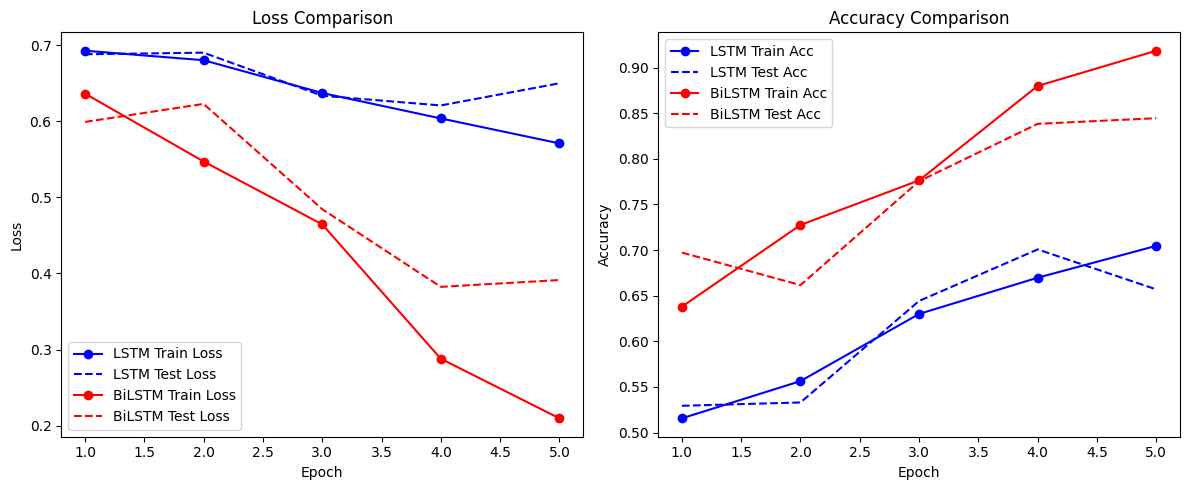

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, 6)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, lstm_train_losses, 'b-o', label='LSTM Train Loss')
plt.plot(epochs, lstm_test_losses, 'b--', label='LSTM Test Loss')
plt.plot(epochs, bilstm_train_losses, 'r-o', label='BiLSTM Train Loss')
plt.plot(epochs, bilstm_test_losses, 'r--', label='BiLSTM Test Loss')
plt.title("Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, lstm_train_accs, 'b-o', label='LSTM Train Acc')
plt.plot(epochs, lstm_test_accs, 'b--', label='LSTM Test Acc')
plt.plot(epochs, bilstm_train_accs, 'r-o', label='BiLSTM Train Acc')
plt.plot(epochs, bilstm_test_accs, 'r--', label='BiLSTM Test Acc')
plt.title("Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
print("Final Results")
print(f"LSTM - Test Accuracy: {lstm_test_accs[-1]:.2f}")
print(f"BiLSTM - Test Accuracy: {bilstm_test_accs[-1]:.2f}")


Final Results
LSTM - Test Accuracy: 0.66
BiLSTM - Test Accuracy: 0.84
